In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

### Tarea 1
Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

In [ ]:
# Leer la imagen de las monedas
img = cv2.imread('./content/Monedas.jpg') 

# Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Umbralizado binario invertido
blur = cv2.GaussianBlur(img_gris,(5,5),0)
ret, img_th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Buscamos los contornos
contours, hierarchy = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Guardamos las coordenadas del centro y el radio de cada círculo 
circles = []

for cnt in contours:
    epsilon = 0.1 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    (x,y), radius = cv2.minEnclosingCircle(approx)
    center = (int(x),int(y))
    radius = int(radius)
    if radius*2 < img.shape[0] and radius*2 < img.shape[1]:
        circles.append([center, radius])

valores = [
    [25.75, 2.00],
    [23.25, 1.00],
    [24.25, 0.50,],
    [22.25, 0.20,],
    [19.75, 0.10,],
    [21.25, 0.05,],
    [18.75, 0.02,],
    [16.25, 0.01]
]

selected = False

# Función para detectar clics en la imagen
def click(event, x, y, flags, param):
    global selected
    moneda_2 = None
    escala = 0
    total_monedas = 0
    # Si presionoo el botón izquierdo del ratón
    if event == cv2.EVENT_LBUTTONDOWN:
        # Recorro los contornos para ver si he hecho clic en alguno
        for index, (center, r) in enumerate(circles):
            # x, y
            cx, cy = center
            # Si hago click dentro del radio
            left = (x - cx)**2 + (y - cy)**2
            right = r**2
            if left <= right:
                # Determino el valor de la moneda y su tamaño
                moneda_2 = index
                break
    if moneda_2 is not None and selected is False:
        r2 = circles[moneda_2][1]
        escala = 25.75/(r2*2)
        for (center, r) in circles:
            tamaño = (r*2)*escala
            for [mm, moneda] in valores:
                if tamaño <= (mm + 0.5) and tamaño >= (mm - 0.5):
                    cv2.circle(img, center, r, (255, 0, 0), 3)
                    moneda = int(moneda*100)
                    total_monedas += moneda
        selected = True
        # Show text
        text = f'Total: {total_monedas/100}'
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = img.shape[0]/400
        grosor = int(font_scale)+3
        text_size = cv2.getTextSize(text, font_face, font_scale, grosor)[0][1]
        print(text_size)
        cv2.putText(img, text, (40, (text_size+50)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,255,0), grosor)
        cv2.imshow("Testing", img)

cv2.namedWindow("Testing", cv2.WINDOW_NORMAL)

ratio = 1
if img.shape[0] > 900:
    ratio = img.shape[0] / 900
elif img.shape[1] > 1800:
    ratio = img.shape[1] / 1800
new_h = int(img.shape[0]//ratio)
new_w = int(img.shape[1]//ratio)
cv2.resizeWindow("Testing", new_w, new_h)
cv2.setMouseCallback("Testing", click)
cv2.imshow("Testing", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Tarea 2.

NOTA: Podemos usar técnicas de segmentación más potentes para distinguir los objetos del fondo. 
RECORDAR: No se espera una clasificación ni separación del 100%, si se consigue, pues genial, pero no es requisito.

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

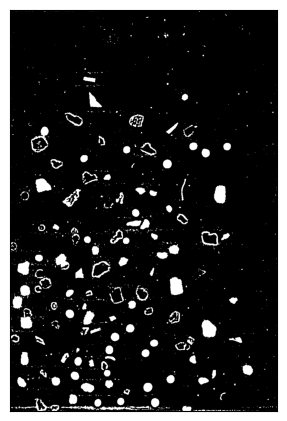

In [3]:
#Carga imagen directamente en grises
imgorig = cv2.imread('./content/MPs_test.jpg', cv2.IMREAD_GRAYSCALE)

img = cv2.GaussianBlur(imgorig,(5,5),0)

# Umbralizado
imth3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

res, imth = cv2.threshold(255 - imth3,120,255,cv2.THRESH_BINARY)
contornos, hierarchy= cv2.findContours(imth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
img_cont = np.zeros(img.shape)
plt.figure(figsize=(20,20))
cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
plt.subplot(2,5,7),plt.imshow(img_cont,'gray')
plt.xticks([]),plt.yticks([])

plt.show()    

Usamos las muestras de entrenamiento para identificar las características de cada grupo

Fragments: [458.0, 764.0, 762.5, 3933.5, 1913.5, 480.0, 695.5, 1039.0, 500.5, 4185.0] [400.96045756340027, 486.6589415073395, 282.5512957572937, 300.1492751836777, 930.4478249549866, 340.04876959323883, 366.91882729530334, 594.4995608329773, 367.06096255779266, 282.24978029727936] [351.0246474442168, 309.995975587754, 104.70194719229593, 22.903161915161323, 452.43436371228916, 240.90242854557422, 193.5721435280527, 340.16335691107105, 269.198302165541, 19.035827593276576] [0.2686217008797654, 0.13102383810667123, 0.19702842377260982, 0.6726231190150479, 2.174431818181818, 0.5860805860805861, 0.24532627865961198, 0.11400043888523151, 0.9625, 0.7188251459979389] [1.7741935483870968, 2.4285714285714284, 1.9111111111111112, 0.7906976744186046, 35.2, 10.11111111111111, 1.4, 0.9489795918367347, 0.19230769230769232, 1.1549295774647887] [0.29485094453617544, 0.6361879811063096, 0.7205664765028529, 0.47746049524895734, 0.48130942708404323, 0.26095187684819043, 0.8159703057570254, 0.672597388575

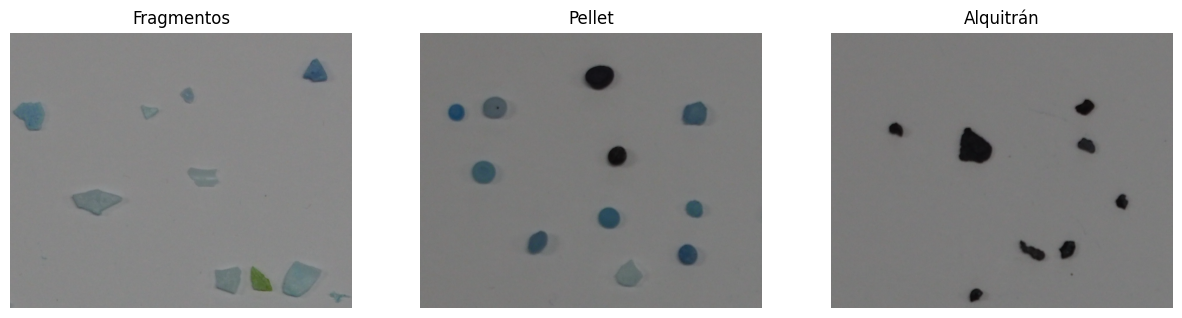

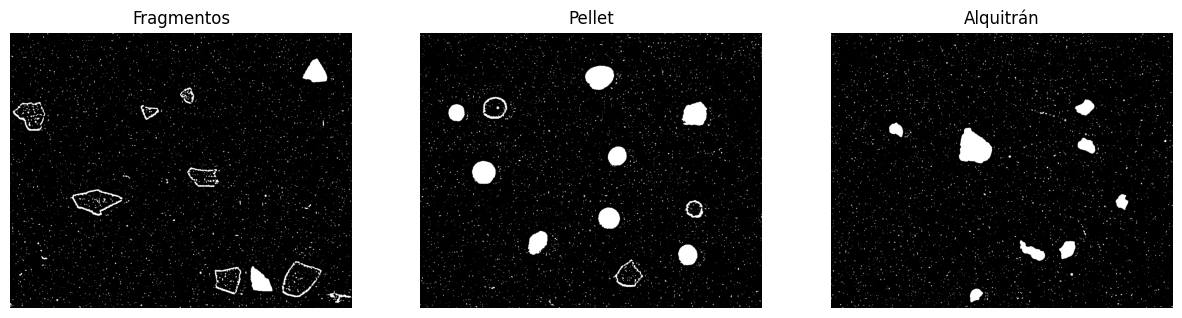

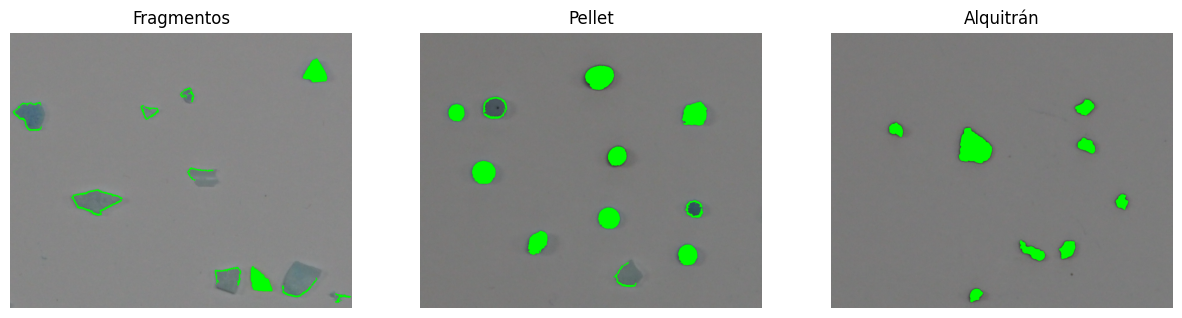

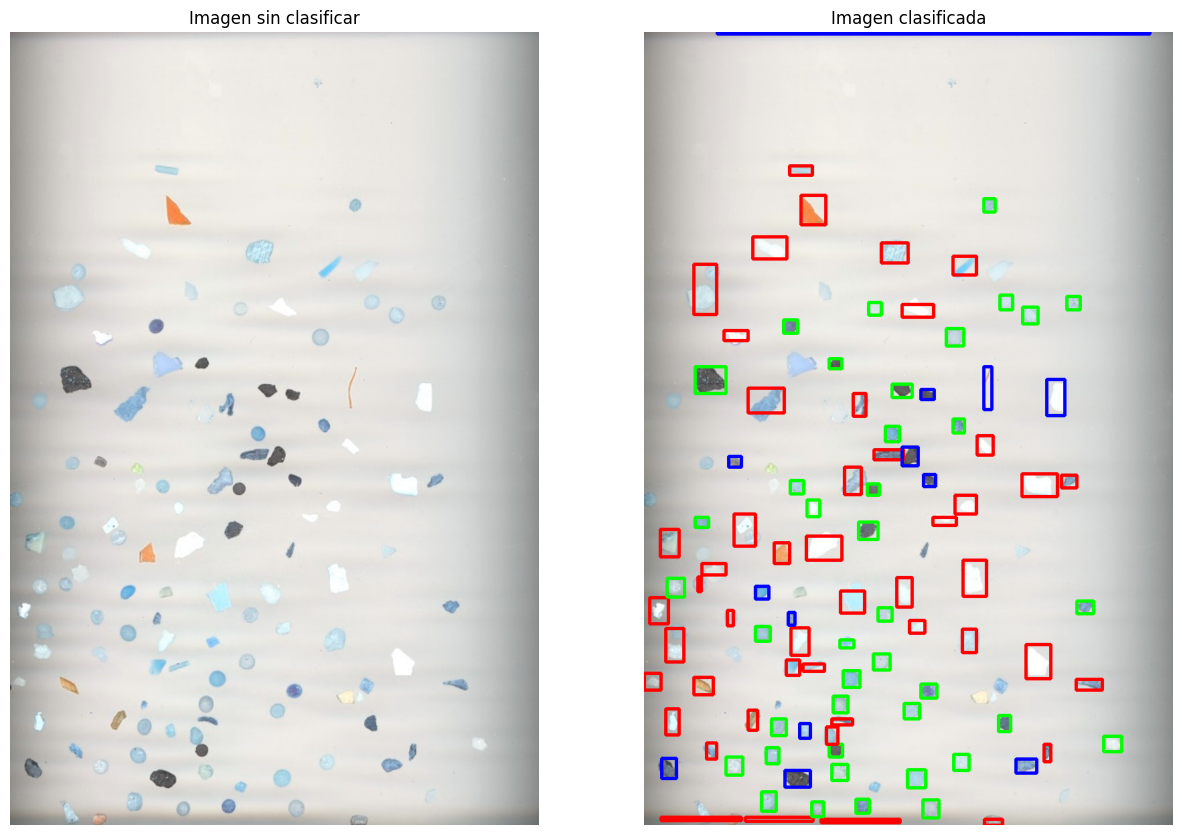

In [ ]:
def show(img1, img2, img3, is_gray):
    fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(15, 4))
    ax1.set_axis_off()
    ax1.set_title('Fragmentos')
    if is_gray:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)

    ax2.set_axis_off()
    ax2.set_title('Pellet')
    if is_gray:
        ax2.imshow(img2, cmap='gray') 
    else:
        ax2.imshow(img2)

    ax3.set_axis_off()
    ax3.set_title('Alquitrán')
    if is_gray:
        ax3.imshow(img3, cmap='gray') 
    else:
        ax3.imshow(img3) 

def process_image(img_path, min_area, min_perim):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    img_blurred = cv2.GaussianBlur(img,(5,5),0)
    img_th = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    res, img_th2 = cv2.threshold(255 - img_th,120,255,cv2.THRESH_BINARY)
    cnt, hierarchy = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_cnt = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(img_cnt, cnt, -1, (255,255,255), -1)  
    img_color = cv2.imread(img_path)
    
    # Area
    areas = [cv2.contourArea(c) for c in cnt if cv2.contourArea(c) > min_area]
    areas_aux = [[cv2.contourArea(c), c] for c in cnt if cv2.contourArea(c) > min_area]

    # Perim
    perims = [cv2.arcLength(c, True) for c in cnt if cv2.arcLength(c, True) > min_perim]

    # Compactness
    compact = [(p**2)/a for p, a in zip(perims, areas)]

    # Area to container ratio
    a2c_ratio = []
    selected_cnt = []
    for (area, c) in areas_aux:
        epsilon = 0.1*cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        container_area = w*h
        a2c_ratio.append(area/container_area)
        # Guardamos los contornos seleccionados en un array aparte
        selected_cnt.append(c)

    # Width to height ratio
    w2h_ratio = []
    for (area, c) in areas_aux:
        epsilon = 0.1*cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if h > 0:
            w2h_ratio.append(w/h)

    # Axis ratio
    axis_ratio = []
    for (area, c) in areas_aux:
        ellipse = cv2.fitEllipse(c)
        (center, axes, angle) = ellipse
        axis_ratio.append(min(axes)/max(axes))

    # Dibujamos los contornos que hemos seleccionado

    img_selected_cnt = img_color.copy()
    cv2.drawContours(img_selected_cnt, selected_cnt, -1, (0, 255, 0), -1)

    return cnt, img_cnt, img_color, areas, perims, compact, a2c_ratio, w2h_ratio, axis_ratio, img_selected_cnt

cnt1, img_cnt1, img1, area1, perim1, compact1, a2c_ratio1, w2h_ratio1, axis_ratio1, img1_1 = process_image('./content/FRA.png', 410, 250)
cnt2, img_cnt2, img2, area2, perim2, compact2, a2c_ratio2, w2h_ratio2, axis_ratio2, img2_1 = process_image('./content/PEL.png', 410, 195)
cnt3, img_cnt3, img3, area3, perim3, compact3, a2c_ratio3, w2h_ratio3, axis_ratio3, img3_1 = process_image('./content/TAR.png', 410, 150)

print("Fragments:", area1, perim1, compact1, a2c_ratio1, w2h_ratio1, axis_ratio1)
print("Pellets:", area2, perim2, compact2, a2c_ratio2, w2h_ratio2, axis_ratio2)
print("Tar:", area3, perim3, compact3, a2c_ratio3, w2h_ratio3, axis_ratio3)

# Mostramos las imágenes originales
show(img1, img2, img3, False)
# Mostramos los contornos detectados
show(img_cnt1, img_cnt2, img_cnt3, True)
# Mostramos los contornos seleccionados tras el filtrado por características
show(img1_1, img2_1, img3_1, False)

def classifier(img_path, min_comp, max_comp, min_w2hr, max_w2hr, min_axr, max_axr, min_area):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    img_blurred = cv2.GaussianBlur(img,(5,5),0)
    img_th = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    res, img_th2 = cv2.threshold(255 - img_th,120,255,cv2.THRESH_BINARY)
    cnt, hierarchy = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_color = cv2.imread(img_path)

    classified_cnt = []

    for c in cnt:
        # Compactness and width to height ratio to find fragments
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c, True)
        if area < min_area or len(c) < 5:
            continue

        comp = (perim**2)/area
        epsilon = 0.1*cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        w2h_ratio = w/h

        classified = False

        if comp >= min_comp and comp <= max_comp and w2h_ratio >= min_w2hr and w2h_ratio <= max_w2hr:
            # Fragments = RED
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (255, 0, 0), 3)
            classified_cnt.append(["FRA", x, y, x+w, y+h])
            classified = True

        # Axis ratio to find pellets
        ellipse = cv2.fitEllipse(c)
        (center, axes, angle) = ellipse
        axis_ratio = min(axes)/max(axes)
        if classified == False and axis_ratio >= min_axr and axis_ratio <= max_axr:
            # Pellets = GREEN
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 3)
            classified_cnt.append(["PEL", x, y, x+w, y+h])
            classified = True
        
        if classified == False:
            # Tar = BLUE
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 0, 255), 3)
            classified_cnt.append(["TAR", x, y, x+w, y+h])

    return img_color, classified_cnt

testing_img = cv2.imread('./content/MPs_test.jpg')
min_area = 150
print(min_area)
classified_img, classified_cnt = classifier('./content/MPs_test.jpg', min(compact1), max(compact1), min(w2h_ratio1), max(w2h_ratio1), min(axis_ratio2), max(axis_ratio2), min_area)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.set_axis_off()
ax1.set_title("Imagen sin clasificar")
ax1.imshow(testing_img)

ax2.set_axis_off()
ax2.set_title("Imagen clasificada")
ax2.imshow(classified_img)

# Se va a leer el csv "MPS_test.csv" y se van a guardar los datos en un array
 
with open('./content/MPS_test_bbs.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    header = next(reader)
    mps_test = [row for row in reader]
 
print(len(mps_test))
print(mps_test)
    
    

Código para crear el archivo .csv de donde hemos extraído las características para el clasificador

In [ ]:
def build_dataframe(label, areas, perims, compacts, a2c_ratios, w2h_ratios, axis_ratios):
    data = {
        'Label': label,
        'Area': areas,
        'Perimeter': perims,
        'Compactness': compacts,
        'Area_to_Container_Ratio': a2c_ratios,
        'Width_to_Height_Ratio': w2h_ratios,
        'Axis_Ratio': axis_ratios
    }
    return pd.DataFrame(data)

df_fragments = build_dataframe('Fragmentos', area1, perim1, compact1, a2c_ratio1, w2h_ratio1, axis_ratio1)
df_pellets = build_dataframe('Pellet', area2, perim2, compact2, a2c_ratio2, w2h_ratio2, axis_ratio2)
df_tar = build_dataframe('Alquitrán', area3, perim3, compact3, a2c_ratio3, w2h_ratio3, axis_ratio3)

df = pd.concat([df_fragments, df_pellets, df_tar], ignore_index=True)

df_numeric = df.select_dtypes(include=['float', 'int']).applymap(lambda x: str(x).replace('.', ','))

for col in df_numeric.columns:
    df[col] = df_numeric[col]

df.to_csv('particle_features.csv', index=False, sep=';')

In [7]:
def media(lista):
    return sum(lista)/len(lista)

print("Area fragmentos", media(area1))
print("Area pellets", media(area2))
print("Area tar", media(area3))

print("--------------------------------------")

print("Perimetro fragmentos", media(perim1))
print("Perimetro pellets", media(perim2))
print("Perimetro tar", media(perim3))

print("--------------------------------------")

print("Compactness fragmentos", media(compact1))
print("Compactness pellets", media(compact2))
print("Compactness tar", media(compact3))

print("--------------------------------------")

print("Area to container ratio fragmentos", media(a2c_ratio1))
print("Area to container ratio pellets", media(a2c_ratio2))
print("Area to container ratio tar", media(a2c_ratio3))

print("--------------------------------------")

print("Width to height ratio fragmentos", media(w2h_ratio1))
print("Width to height ratio pellets", media(w2h_ratio2))
print("Width to height ratio tar", media(w2h_ratio3))

print("--------------------------------------")

print("Axis ratio fragmentos", media(axis_ratio1))
print("Axis ratio pellets", media(axis_ratio2))
print("Axis ratio tar", media(axis_ratio3))




Area fragmentos 1473.15
Area pellets 3301.5
Area tar 2831.3125
--------------------------------------
Perimetro fragmentos 435.15456955432893
Perimetro pellets 319.8555981571024
Perimetro tar 217.5460925102234
--------------------------------------
Compactness fragmentos 230.3932154595233
Compactness pellets 72.6674463079967
Compactness tar 19.04169939876367
--------------------------------------
Area to container ratio fragmentos 0.6070461349579281
Area to container ratio pellets 0.7619148276035955
Area to container ratio tar 0.7921912698722103
--------------------------------------
Width to height ratio fragmentos 5.591190173520857
Width to height ratio pellets 0.9013230050366623
Width to height ratio tar 1.0102915355596893
--------------------------------------
Axis ratio fragmentos 0.6126878747522126
Axis ratio pellets 0.8655030311474872
Axis ratio tar 0.6711621225963896
